### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 12th at 11.59pm CT
---

## Problem 1

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [130]:
#Imports 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [131]:
# Question 1
data=np.load('../../../homeworks/hw_data/hw8_data_1.npy')
print(data.dtype.names)

#Colors
u_g= data['u'] - data['g']
g_r= data['g'] - data['r']
r_i= data['r'] - data['i']
i_z= data['i'] - data['z']


spec_class= data['specClass'] #Spectral Class
redshifts= data['redshift'] #Redshift

unique, counts = np.unique(spec_class, return_counts=True) #Gets the amount of unique labels and thier counts
print(f"{unique[0]} Count: {counts[0]}, {unique[1]} Count: {counts[1]}") #Print statment

('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
GALAXY Count: 42808, QSO Count: 7192


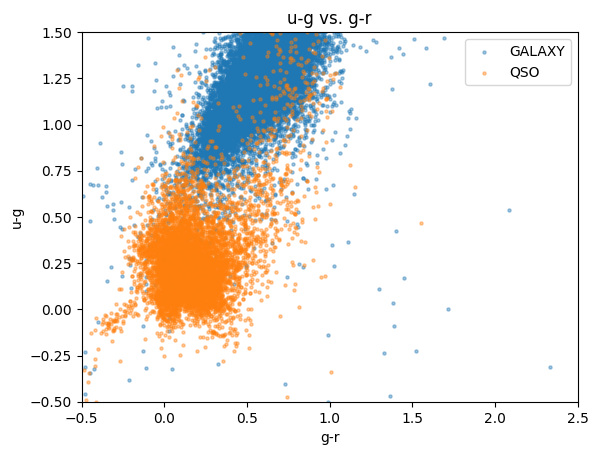

In [132]:
#Question 2
galaxy_mask= (spec_class == 'GALAXY') #Mask for only galaxies 
qso_mask= (spec_class == 'QSO') #Mask for only QSOs

#Plotting
plt.scatter(g_r[galaxy_mask], u_g[galaxy_mask], s=5, alpha=0.4, label="GALAXY")
plt.scatter(g_r[qso_mask], u_g[qso_mask], s=5, alpha=0.4, label="QSO")
plt.xlabel('g-r')
plt.ylabel('u-g')
plt.title('u-g vs. g-r')
plt.xlim(-0.5, 2.5) 
plt.ylim(-0.5, 1.5)
plt.legend()
plt.show()

In [133]:
#Question 3
X = np.stack([u_g, g_r, r_i, i_z, redshifts], axis=1) #Stack 4 colors + redshift

label= np.where(spec_class=='GALAXY',0,1) #Make an array where 'GALAXY' = 0, and everything else ('QSO') = 1

#Test Split
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2) #80/20 split

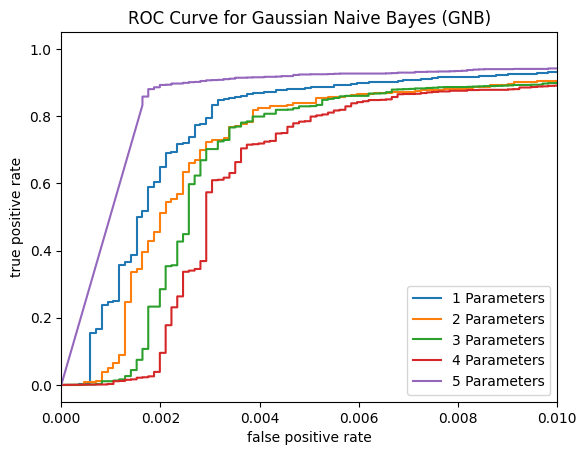

In [134]:
#Problem 4

for i in range(len(X[0, :])): #Loop through columns of X
    #Train Model
    gnb = GaussianNB()
    gnb.fit(X_train[:, :i+1],y_train) #Takes up to the (i+1)th coulmn

    #Predict on Test Sample
    y_pred = gnb.predict_proba(X_test[:,:i+1])[:,1] #Probability of QSO
    fpr, tpr, thresh = roc_curve(y_test, y_pred)
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label=f"{i+1} Parameters")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve for Gaussian Naive Bayes (GNB)")
plt.xlim(0,0.01)
plt.legend()
plt.show()


ROC curve increses faster when the fifth parameter, redshift (z), is included into the GNB model

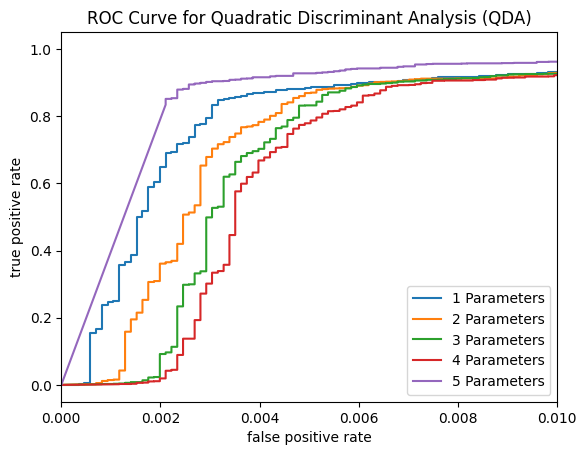

In [135]:
#Problem 5

for i in range(len(X[0, :])): #Loop through columns of X
    #Train Model
    qda = QDA()
    qda.fit(X_train[:, :i+1],y_train) #Takes up to the (i+1)th coulmn

    #Predict on Test Sample
    y_pred = qda.predict_proba(X_test[:,:i+1])[:,1] #Probability of QSO

    fpr, tpr, thresh = roc_curve(y_test, y_pred)
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label=f"{i+1} Parameters")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve for Quadratic Discriminant Analysis (QDA)")
plt.xlim(0,0.01)
plt.legend()
plt.show()

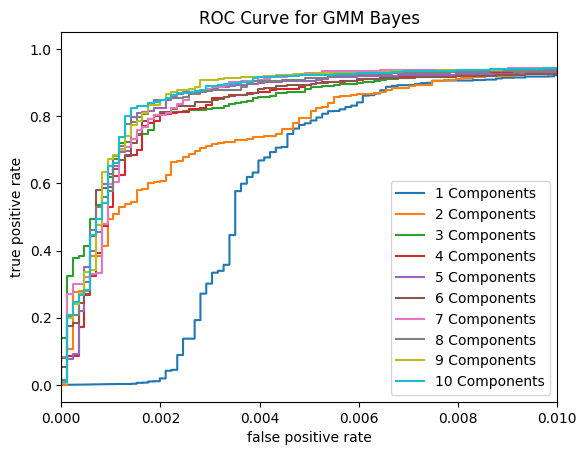

Best number of components: 10 with AUC = 0.9917204863351239


In [136]:
#Problem 6
from sklearn.metrics import roc_curve, roc_auc_score

components=np.arange(1,11)
auc_scores=[] #Stores area under each curve
for N in components: #Loop through number of components (N)
    gmmb = GMMBayes(N) 
    gmmb.fit(X_train[:,:4],y_train)

    y_pred = gmmb.predict_proba(X_test[:,:4])[:,1] #Probability of QSO
    fpr, tpr, thresh = roc_curve(y_test, y_pred) 
    auc = roc_auc_score(y_test, y_pred) #Finds Area Under Curve (AUC)
    auc_scores.append(auc)
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label=f"{N} Components")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve for GMM Bayes")
plt.xlim(0,0.01)
plt.legend()
plt.show()

best_N = components[np.argmax(auc_scores)]
print(f"Best number of components: {best_N} with AUC = {max(auc_scores)}")

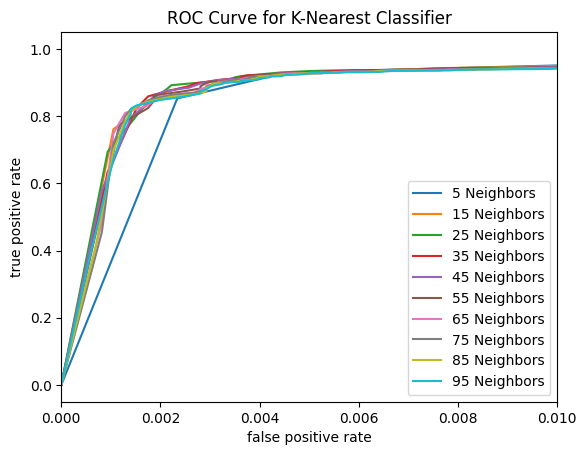

Best number of Neighbors: 95 with AUC = 0.9922629274730448


In [137]:
#Problem 7  Repeat (6) for $K$-nearest neighbor classification
neighbors= np.arange(5,101, 10)
auc_scores=[] #Stores area under each curve
for N in neighbors: #Loops through Number of Neighbors
    knc = KNeighborsClassifier(N) 
    knc.fit(X_train[:,:4],y_train)

    y_pred = knc.predict_proba(X_test[:,:4])[:,1] #Probability of QSO

    #Get only quasars in predicted labels
    fpr, tpr, thresh = roc_curve(y_test, y_pred) 
    auc = roc_auc_score(y_test, y_pred) #Finds area under ROC curve
    auc_scores.append(auc)
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label=f"{N} Neighbors")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve for K-Nearest Classifier")
plt.xlim(0,0.01)
plt.legend()
plt.show()

best_neighbors = neighbors[np.argmax(auc_scores)]
print(f"Best number of Neighbors: {best_neighbors} with AUC = {max(auc_scores)}")

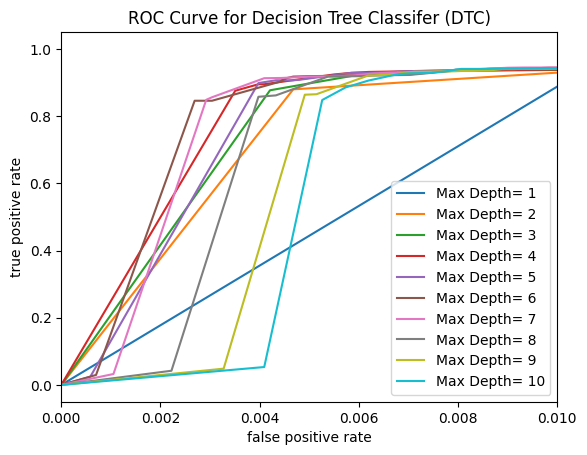

Best Max Depth: 6 with AUC = 0.9746950137940692


In [138]:
#Problem 8
depths= np.arange(1,11)
auc_scores=[] #Stores area under each curve

for N in depths: #Loops through max_depths for Decision Tree Classifier
    dtc = DecisionTreeClassifier(max_depth=N) 
    dtc.fit(X_train[:,:4],y_train)
    y_pred = dtc.predict_proba(X_test[:,:4])[:,1] #Probability of QSO
    fpr, tpr, thresh = roc_curve(y_test, y_pred)

    auc = roc_auc_score(y_test, y_pred) #Finds area under ROC curve
    auc_scores.append(auc)
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label=f"Max Depth= {N}")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve for Decision Tree Classifer (DTC)")
plt.xlim(0,0.01)
plt.legend()
plt.show()

best_depth = depths[np.argmax(auc_scores)]
print(f"Best Max Depth: {best_depth} with AUC = {max(auc_scores)}")

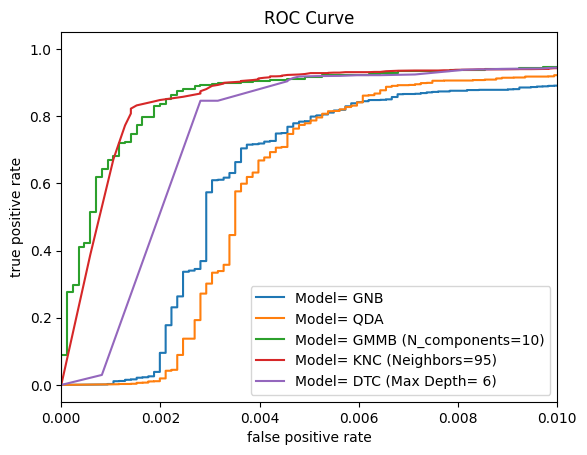

Best Model: KNC (Neighbors=95) with AUC = 0.9922629274730448


In [139]:
#Problem 9
# Initialize all models and their best fit parameters (if applicable) 
gnb = GaussianNB()
qda = QDA()
gmmb = GMMBayes(best_N)
knc = KNeighborsClassifier(best_neighbors)
dtc = DecisionTreeClassifier(max_depth=best_depth) 


models=[gnb, qda, gmmb, knc, dtc]
model_names=[f"GNB", f"QDA", f"GMMB (N_components={best_N})", f"KNC (Neighbors={best_neighbors})", f"DTC (Max Depth= {best_depth})" ]
auc_models=[]
for i,model in enumerate(models): #Loop through all models 
    model.fit(X_train[:,:4], y_train)
    y_pred = model.predict_proba(X_test[:,:4])[:,1]
    fpr, tpr, thresh = roc_curve(y_test, y_pred)

    auc = roc_auc_score(y_test, y_pred)
    auc_models.append(auc)
    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    plt.plot(fpr, tpr, label=f"Model= {model_names[i]}")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve")
plt.xlim(0,0.01)
plt.legend()
plt.show()

#Find best model
best_model = model_names[np.argmax(auc_models)]
print(f"Best Model: {best_model} with AUC = {max(auc_models)}")







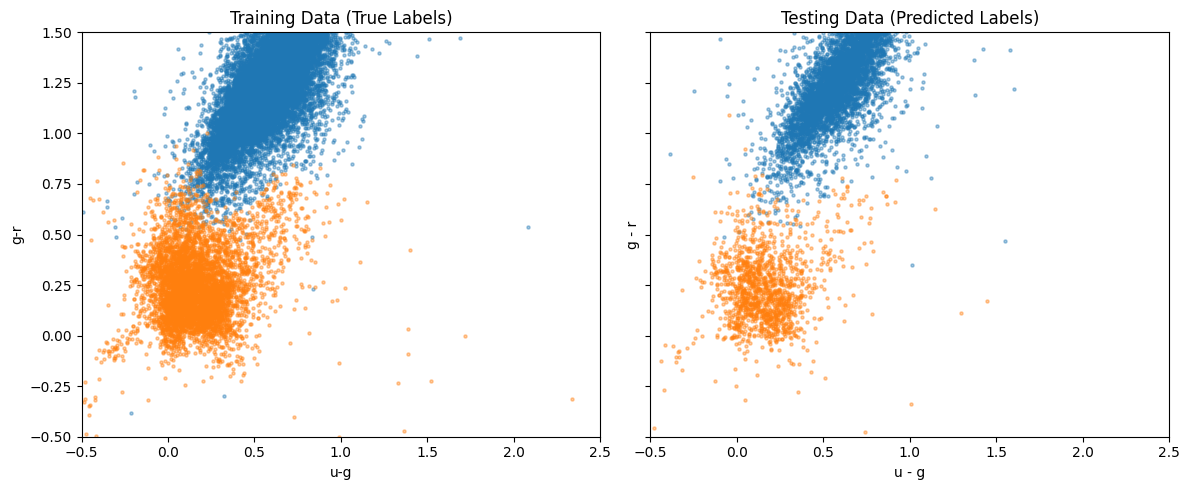

In [140]:
#Problem 10
best_model = models[np.argmax(auc_models)] #Get best model from cell above
# Fit best model to 4 color features
best_model.fit(X_train[:, :4], y_train)

# Predict classes on test data
y_train_pred= best_model.predict(X_train[:, :4])
y_test_pred = best_model.predict(X_test[:, :4])

# Setup 2-panel plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Training data with predicted labels
galaxy_mask= (y_train_pred == 0)
qso_mask= (y_train_pred == 1)
axs[0].scatter(X_train[:, 1][galaxy_mask], X_train[:, 0][galaxy_mask], s=5, alpha=0.4, label="Galaxy")
axs[0].scatter(X_train[:, 1][qso_mask], X_train[:, 0][qso_mask], s=5, alpha=0.4, label="QSO")
axs[0].set_title('Training Data (True Labels)')
axs[0].set_xlabel('u-g')
axs[0].set_ylabel('g-r')
axs[0].set_xlim(-0.5, 2.5) 
axs[0].set_ylim(-0.5, 1.5)

# Testing data with predicted labels
galaxy_mask= (y_test_pred == 0)
qso_mask= (y_test_pred == 1)
axs[1].scatter(X_test[:, 1][galaxy_mask], X_test[:, 0][galaxy_mask], s=5, alpha=0.4, label="Galaxy")
axs[1].scatter(X_test[:, 1][qso_mask], X_test[:, 0][qso_mask], s=5, alpha=0.4, label="QSO")
axs[1].set_title('Testing Data (Predicted Labels)')
axs[1].set_xlabel('u - g')
axs[1].set_ylabel('g - r')
axs[1].set_xlim(-0.5, 2.5) 
axs[1].set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

## Problem 2

The first few steps of this problem are the same as the previous problem.


1. Read in the same galaxy color data used above. Slice the data array to only take every other 10th row. From this reduced data volume, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. 


2. We're going to make classification pretty tough for our deep neural network. Make a scatter plot of $(r-i)$ versus $(i-z)$, color coding by galaxy or quasar class. Notice how much more difficult the visual discrimination is compared to $(u-g)$ versus $(g-r)$. The plot should include appropriate axis labels and a legend.


3. Stack the $(r-i)$ and $(i-z)$ colors into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing. Set the `random_state` in your train-test split to be `42` for reproducibility (and easy comparison with my solutions).


4. Scale your training and testing data to prepare it for the DNN. 


5. Train scikit-learn's multi-layer perceptron classifier with ReLU activation, stochastic gradient descent, two hidden layers of respective sizes of $5$ and $2$, and using `max_iter=1000`, and `random_state=42`. As with classifiers in last week's homework, plot an ROC curve that shows the network's performance on the scaled testing data. 


6. Now let's optimize the hyperparameters of your network. You will use `GridSearchCV` with the following hyperparameters for the network:

```
parameters = {'solver': ['lbfgs', 'sgd', 'adam'], 
              'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)], 
              'activation': ['relu', 'tanh'], 
              'random_state': [42], 'max_iter': [1000]}
```

Remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.


7. Fit a new DNN using the best hyperparameters obtained in (6), and make a plot that has ROC curves for this new network and your original network. Let the x and y axes have the full limit range of 0 to 1. Voila!

In [141]:
#Problem 1
#Take every 10th index of data set
every_10th= np.arange(0,len(data), 10)
every_10th= every_10th[1:] #get rid of the 0th 
X_colors_10th= X[every_10th, :4] 
label_10th= label[every_10th]
redshifts_10th= redshifts[every_10th]

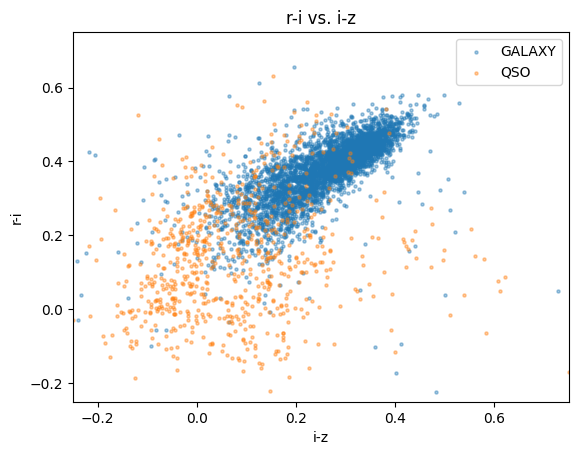

In [142]:
#Problem 2
galaxy_mask= (label_10th == 0)
qso_mask= (label_10th == 1)

plt.scatter(X_colors_10th[galaxy_mask, 3], X_colors_10th[galaxy_mask, 2], s=5, alpha=0.4, label="GALAXY")
plt.scatter(X_colors_10th[qso_mask, 3], X_colors_10th[qso_mask, 2], s=5, alpha=0.4, label="QSO")
plt.xlabel('i-z')
plt.ylabel('r-i')
plt.title('r-i vs. i-z')
plt.xlim(-0.25,0.75)
plt.ylim(-0.25,0.75)
plt.legend()
plt.show()

In [143]:
#Problem 3
X = np.stack([X_colors_10th[:,2], X_colors_10th[:,3]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, label_10th, test_size=0.2, random_state=42) #80/20 split

In [144]:
#Problem 4
#Scale Data
X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)
X_scaled = preprocessing.scale(X)

/tmp/ipykernel_12712/2645107055.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


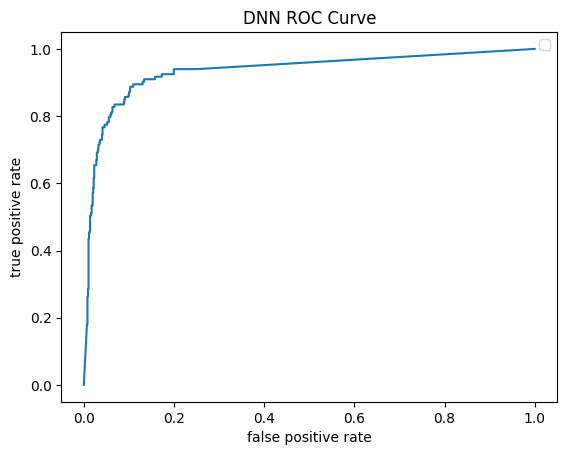

In [145]:
#Problem 5

clf = MLPClassifier(activation='relu', solver='sgd', hidden_layer_sizes=(5, 2), max_iter=1000,random_state=42)
clf.fit(X_train_scaled, y_train)



y_pred = clf.predict_proba(X_test_scaled)[:,1]


fpr, tpr, thresh = roc_curve(y_test, y_pred)
# add (0, 0) as first point
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])

plt.plot(fpr, tpr)

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("DNN ROC Curve")
plt.legend()
plt.show()


In [146]:
#Parameters
parameters = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'hidden_layer_sizes': [(2,2), (5,5), (5,2), (5,5,5)],
    'activation': ['relu', 'tanh'],
    'random_state': [42],
    'max_iter': [1000]
}

# Model
clf = MLPClassifier()

# Grid search with CV
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, cv=5)

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Predict on training data
y_train_pred = grid_search.predict(X_train)
train_score = accuracy_score(y_train, y_train_pred)

# Print results
print(f"Training accuracy: {train_score:.3f}")
print("Best hyperparameters found:")
print(grid_search.best_params_)

/home/hernab6/anaconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/hernab6/anaconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/hernab6/anaconda3/envs/astr8070/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Converg

Training accuracy: 0.934
Best hyperparameters found:
{'activation': 'relu', 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 1000, 'random_state': 42, 'solver': 'adam'}


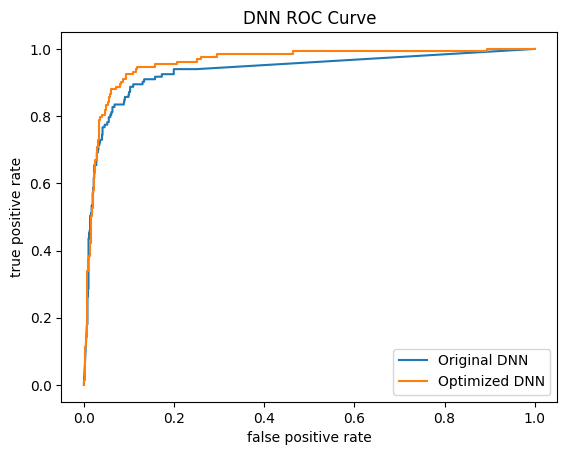

In [147]:
clf_best = MLPClassifier(activation='relu', solver='adam', hidden_layer_sizes=(5, 5, 5), max_iter=1000, random_state=42) #from best hyperparameters found
clf_best.fit(X_train_scaled, y_train)


y_pred_best = clf_best.predict_proba(X_test_scaled)[:,1]


fpr_best, tpr_best, thresh_best = roc_curve(y_test, y_pred_best)
# add (0, 0) as first point
fpr_best = np.concatenate([[0], fpr_best])
tpr_best = np.concatenate([[0], tpr_best])

plt.plot(fpr, tpr, label=f"Original DNN")
plt.plot(fpr_best, tpr_best, label=f"Optimized DNN")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("DNN ROC Curve")
plt.legend()
plt.show()